Data sets format: 
files:
* TotalFlights.csv
* DelayFlights.csv
* DelayRatio.csv
* airport2idx.csv
* time_stamp2idx.csv
* test.csv
* readme.ipynb

this.ipynb provide helper function to generate the following data:

* `TotalFlights`: pd.DataFrame with value  of shape (A,N)

`TotalFlights[i,t]` is number of flights between [`idx2time_stamp[t]`,`idx2time_stamp[t] + dt`) at airport `idx2airport[i]`

* `DelayFlights`: pd.DataFrame with value of shape (A,N)

`DelayFlights[i,t]` is number of delayed flights between [`idx2time_stamp[t]`,`idx2time_stamp[t] + dt`) at airport `idx2airport[i]`

* `DelayRatio`:  pd.DataFrame with value of shape (A,N)

`DelayRatio[i,t] = DelayFlights[i,t] / TotalFlights[i,t]`


* `idx2airport`: dict 

`idx2airport[i]` return  the iata name for airport index ` i `

* `airport2idx`: dict

inverse to `idx2airport`

* `idx2time_stamp`: dict

`idx2time_stamp[t]` return  the timestamp for time index ` t `

* `time_stamp2idx`: dict

inverse to `idx2time_stamp[t]`

* `dt`:pd.TimeDelta 

`1D` or `1H` so far

* `test_index` :list of lenth M
element is time index at which model predicts the delay ratio. In our case, all elements `tidx in test_index`' satisfy `idx2time_stamp[tidx]` after `2018-01-01 00:00:00`

`readme.ipynb` also provide a model evaluation function `model_mse(pred_data)`. 

* 1. run next block to generate data
* 2. tune your model, generate a np.ndarrays obeject `pred_data` of shape  `(A,M)`
`pred_data[:,j]` gives the predicted delay ratio for time index `test_index[j]`
* 3. report `model_mse(pred_data)`, save `pred_data`

In **this** notebook, `dt` is 1 day. datasets contain `pd.date_range('2007-01-01 00:00:00','2008-12-30 00:00:00',freq='d')` as time stamp. 
When using model to pridiction. one **CAN NOT** use the data at or after `idx2time_stamp[t]` to

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
def fun25_import_datasets():
    idx2airport=pd.read_csv("idx2airport.csv",index_col=0)['0'].to_dict()
    airport2idx=pd.read_csv("airport2idx.csv",index_col=0)['0'].to_dict()
    idx2time_stamp=pd.read_csv("idx2time_stamp.csv",index_col=0)['0'].to_dict()
    time_stamp2idx=pd.read_csv("time_stamp2idx.csv",index_col=0)['0'].to_dict()
    TotalFlights=pd.read_csv("TotalFlights.csv",index_col=0)
    DelayFlights=pd.read_csv("DelayFlights.csv",index_col=0)
    DelayRatio=pd.read_csv("DelayRatio.csv",index_col=0)
    test_index=list(pd.read_csv("test.csv",index_col=0,header=None).values.T[0,:])
    dt=timedelta(seconds=3600) #1H
    
    return idx2airport,airport2idx,idx2time_stamp,time_stamp2idx,TotalFlights,DelayFlights,DelayRatio,test_index,dt

def model_mse(pred_data,test_data=None):
    test_index=list(pd.read_csv("test.csv",index_col=0,header=None).values.T[0,:])
    DelayRatio=pd.read_csv("DelayRatio.csv",index_col=0)
    return np.mean(np.mean(np.square(DelayRatio[:,test_index]-pred_data),axis=0))

In [2]:
#Demo 1
idx2airport,airport2idx,idx2time_stamp,time_stamp2idx,TotalFlights,DelayFlights,DelayRatio,test_index,dt=fun25_import_datasets()

In [4]:
type(TotalFlights)

pandas.core.frame.DataFrame

In [6]:
dt

datetime.timedelta(0, 3600)

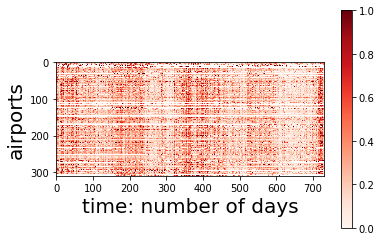

In [11]:
import matplotlib.pyplot as plt

plt.imshow(DelayRatio)
plt.set_cmap('Reds')
plt.xlabel("time: number of days",size=20)
plt.ylabel("airports",size=20)
plt.colorbar()
plt.show()